In [1]:
from rsa import ExtendedEuclideanAlgorithm, SquareAndMultiply, MillerRabin, RSA
from rsa import ProbabilityToBePrime
import random
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import matplotlib.pyplot as plt


# Asymmetric Ciphers

**Asymmetric Ciphers** are cryptographic algorithms that use different keys, called respectively **public and private keys**, for encryption and decryption. This property solves one of the main issues of symmetric ciphers, that was the necessity of a secure channel to share the unique key among Alice and Bob. The entire process follows this scheme:
- Bob generates both the public and the private key
- Bob sends to Alice the private key over a **potentially unsecure channel**, meaning that the public key may be "stolen" by an attacker
- Alice uses the public key to encrypt the plaintext and sends the obtained ciphertext to Bob
- Bob uses the private key to decrypt the ciphertext

The security is guaranteed by how encryption and decryption functions are defined: they are based on what is called **One Way Function**, that is easy to compute in one direction and complex in the opposite one, unless some specific informations are known.

Typically asymmetric ciphers are more expensive than stream or block ciphers: this is why they are used for the key exchange process of symmetric ciphers, in order to pay the cost of the asymmetric cipher only once and then use the symmetric one to send the real message. [[1]](#references)

This notebook will focus on RSA, one of the most used asymmetric ciphers, and on the algorithms involved in it. Subsequently, a possible application of RSA will be implemented coupling it with AES [[6]](#references). Eventually Monte Carlo method will be used to estimate the probability that a very large random number is prime, that is a key aspect of RSA.

## RSA

**RSA** is one of the most used asymmetric ciphers. Unlike stream and block ciphers that we have seen so far, RSA works with integer numbers and not with bit/bytes or text. RSA functioning is described below:
- Bob generates two large prime numbers $p$ and $q$ and computes $n = p \cdot q$
- Bob computes $m = \phi(n) = (p-1)\cdot(q-1)$, called **totient of n**, that counts how many positive integers smaller than $n$ are coprime with it
- Bob computes $e$ and $d$ so that $gcd(e, m) = 1$ and $ed \equiv 1  (\textrm{mod}\ m)$ ($d$ is called **modular inverse of $e$ modulo m**)
- Bob builds the public key as $(n, e)$ and the private key as $(n, d)$
- Bob sends the public key to Alice
- Alice encrypts the plaintext, previously converted into an integer number $x$, computing $y = x^e \backslash n$ and sends the ciphertext $y$ to Bob
- Bob decrypts the ciphertext by doing $x = y^d \backslash n$

If an attacker has the public key $(n, e)$, he needs to compute $m$ and then $d$ to decrpyt the ciphertext. It seems that, once $n$ is known, computing $m$ is easy: in reality $\phi(n)$ can be simply computed only if the factors of $n$ are known but it is extremely complex if they are not. To obtain them, an attacker needs to factorize $n$, that in modern RSA implementations is typically 1024, 2048 or 4096 bits, and this is considered computationally unfeasible. All this constitues the One-Way function employed in RSA. [[2]](#references)

In the following steps we will focus on the algorithms used for the keys generation and encryption and decryption functions.

### Miller Rabin Primality Test

The first thing to generate the keys is to produce two large prime numbers $p$ and $q$. Since there is now way to randomly draw prime numbers, what is done is generating random numbers and then checking whether they are prime. Since factorization is computationally unfeasible for such big numbers, to assess primality we exploit a property that tells with high probability if a number is prime or composite. One of the most used primality tests is the **Miller Rabin Test**: it takes as input an odd number $p$ and finds $q$ and $r$ so that $p = q\cdot2^r+1$. Then at each iteration a random integer is drawn in the interval $[2; p-2]$ and $p$ is tested using **Fermat's Little Theorem**$$p\ is\ prime \Rightarrow\forall x \in \mathbb{Z} \hspace{0.5cm} x^{p}\equiv x\ (\textrm{mod}\ p)$$If $p$ fail the test, it is declared **surely composite**, but if it passes the test it is declared **likely prime (not surely prime)**. In the worst case, the probability to classify a composite number as prime is bounded by $4^{-N_{iterations}}$. [[3]](#references)

In [2]:
# Prime number
n = 6701531651
isprime = MillerRabin(n, 1000)
if isprime:
    print(f'{n} is probably a prime number')
else:
    print(f'{n} is not a prime number')

# Prime number
n = 1962443363
isprime = MillerRabin(n, 1000)
if isprime:
    print(f'{n} is probably a prime number')
else:
    print(f'{n} is not a prime number') 

# Composite number
n = 7863985485
isprime = MillerRabin(n, 1000)
if isprime:
    print(f'{n} is probably a prime number')
else:
    print(f'{n} is not a prime number')

# Composite number = product of 3 big prime numbers
n = 735495555426839*587000395258763*374906457293939
isprime = MillerRabin(n, 1000)
if isprime:
    print(f'{n} is probably a prime number')
else:
    print(f'{n} is not a prime number')



6701531651 is probably a prime number
1962443363 is probably a prime number
7863985485 is not a prime number
161860682384236698774917023853734785426608423 is not a prime number


### Extended Euclidean Algorithm

After $n$ and $m$ are computed, one need to calculate $e$ and $d$ so that $gcd(e, m) = 1$ and $ed\equiv1\ (\textrm{mod}\ m)$. The simplest way to compute the greatest common divisor of two integers numbers requires to factorize them. This time **Extended Euclidean Algorithm** comes to help. The ideas behind this algorithm are the following:
- $m, e \in \mathbb{N}, m > e, m = q\cdot e + r \Rightarrow gcd(m, e) = gcd(e, r)$. This allows to find $gcd(e, m)$ by means of iterative divisions.
- $gcd(e, m) = s\cdot e + t\cdot m,\ gcd(e, m)\equiv1\ (\textrm{mod}\ m) \Rightarrow s\cdot e\equiv1\ (\textrm{mod}\ m)$. This allows to find $d$. [[4]](#references)

In [3]:
a = 39
m = 60
gcd, s, t = ExtendedEuclideanAlgorithm(a, m)
print(f'The GCD of {a} and {m} is {gcd}')
print(f's = {int(s)} and t = {int(t)} are the values so that sa + tm = gcd(a, m),'\
        f' indeed {int(s)}*{a} + {int(t)}*{m} = {gcd}\n')

a = 2560945
m = 98714510
gcd, s, t = ExtendedEuclideanAlgorithm(a, m)
print(f'The GCD of {a} and {m} is {gcd}')
print(f's = {int(s)} and t = {int(t)} are the values so that sa + tm = gcd(a, m),'\
        f' indeed ({int(s)}*{a}) + ({int(t)}*{m}) = {gcd}\n')

# Particular cases
a = 0
m = 2560945
gcd, s, t = ExtendedEuclideanAlgorithm(a, m)
print(f'The GCD of {a} and {m} is {gcd}')
print(f's = {int(s)} and t = {int(t)} are the values so that sa + tm = gcd(a, m),'\
        f' indeed ({int(s)}*{a}) + ({int(t)}*{m}) = {gcd}\n')

a = 25
m = 25
gcd, s, t = ExtendedEuclideanAlgorithm(a, m)
print(f'The GCD of {a} and {m} is {gcd}')
print(f's = {int(s)} and t = {int(t)} are the values so that sa + tm = gcd(a, m),'\
        f' indeed ({int(s)}*{a}) + ({int(t)}*{m}) = {gcd}')


The GCD of 39 and 60 is 3
s = -3 and t = 2 are the values so that sa + tm = gcd(a, m), indeed -3*39 + 2*60 = 3

The GCD of 2560945 and 98714510 is 5
s = 4135267 and t = -107281 are the values so that sa + tm = gcd(a, m), indeed (4135267*2560945) + (-107281*98714510) = 5

The GCD of 0 and 2560945 is 2560945
s = 0 and t = 1 are the values so that sa + tm = gcd(a, m), indeed (0*0) + (1*2560945) = 2560945

The GCD of 25 and 25 is 25
s = 1 and t = 0 are the values so that sa + tm = gcd(a, m), indeed (1*25) + (0*25) = 25


### Square and Multiply

The last issue regards the exponentiations performed during RSA encryption and decryption. Supposing that $n$ is a 2048 bit number (that is a typical value for standard RSA applications), computing $x^e$ and $y^d$ requires a number of multiplications up to $2^{2048}$ that is unaffordable. One algorithm that is able to significantly reduce the number of required operations is called **Square and Multiply**: at first the exponent is computed as the sum of several powers of 2 following its binary rappresentiation. Through some manipulations, this sum can be expressed as a series of multiplications by 2 and additions by 1 that, once it is used as exponent, becomes a sequence of squaring operations and multiplication by the base. The final amount of required operation is much lower than the original one, but it is still quite expensive[[5]](#references)

In [4]:
base = 4
exp = 5
mod = 35
y = SquareAndMultiply(base, exp, mod)
print(f'x^e \\ n = {y}')

x^e \ n = 9


### RSA implementation testing

In [5]:
##### Testing of the RSA class #####

# Inside the class the instructions in the DEBUG branches are executed.
# Then p and q are equal to 335895919357171 and 744053548667773 respectively
bob = RSA(debug = True)
alice = RSA(n = bob.pub_key[0], e = bob.pub_key[1], debug = True)

# To simplify the debug process integers are used instead of bytes
plaintext = 3223675867980
print(f'\nThe plaintext is: {plaintext}')
ciphertext = alice.encrypt(plaintext)
print(f'The ciphertext is: {ciphertext}')
dec_plaintext = bob.decrypt(ciphertext)
print(f'The decrypted plaintext is: {dec_plaintext}')

# Full testing with random p and q, key length equal to 512 bits and
# bytes format for plaintext and ciphertext
bob = RSA(length = 512)
alice = RSA(n = bob.pub_key[0], e = bob.pub_key[1])
plaintext = random.randbytes(20)
print(f'\nThe plaintext is: {plaintext}')
ciphertext = alice.encrypt(plaintext)
print(f'The ciphertext is: {ciphertext}')
dec_plaintext = bob.decrypt(ciphertext)
print(f'The decrypted plaintext is: {dec_plaintext}')
 


The plaintext is: 3223675867980
The ciphertext is: 64091386761571093932794909611
The decrypted plaintext is: 3223675867980

The plaintext is: b'\xc2\xec]\xfb\xd0c\x9a\xca\xc7GB"za\xf3\x81S\xe7\xed\x96'
The ciphertext is: b'\x8eL\xfc\xd37`\x10\xf7\xaa0\xcb\xf3\x9dQ/Ls\xe4\xca\xeb\xec\xf7\xabA\xd4O\x98iee\xc5`\xff\xbe;\xbd\x90&\x03Q\x17\xeb\xb8\x16\x82a\xbas\x82;AT\xf2{c\x10\x1f\xdf\xef\xf9\x16\x82x\xc6'
The decrypted plaintext is: b'\xc2\xec]\xfb\xd0c\x9a\xca\xc7GB"za\xf3\x81S\xe7\xed\x96'


In [6]:
# The plaintext is chosen so that it is longer than the key length. For this reason
# it cannot be encrypted. Let's see if an error is raised...
bob = RSA(length = 20)
print(bob.pub_key)
print(bob.priv_key)
alice = RSA(n = bob.pub_key[0], e = bob.pub_key[1])
plaintext = random.randbytes(30)
print(f'\nThe plaintext is: {plaintext}')
try:
    ciphertext = alice.encrypt(plaintext)
    print(f'The ciphertext is: {ciphertext}')
    dec_plaintext = bob.decrypt(ciphertext)
    print(f'The decrypted plaintext is: {dec_plaintext}')
except ValueError as e:
    print(e)

(684623, 5)
(684623, 409781)

The plaintext is: b'\xc2\x17\x97\xcc\xaa\xeb3}\x92yx\xdcL\xaa\xa2\x92c\xa7(\xcf\x82g\xa2\x1b\x84\xd0\x8a`v\xd6'
ERROR -> the plaintext to encrypt is too long. Try with a shorter one.


### RSA and AES

As it has been already mentioned, RSA and asymmetric ciphers in general are very expensive if a very long message needs to be encrypted. For this reason they are typically used to guarantee a secure exchange of a stream or block cipher's key that is then used to produce the ciphertext. In the following step a possible implementation is shown where RSA is used to encrypt and decrypt the AES key used to provide encryption and decryption of the real message.

In [7]:
with open('lorem_ipsum.txt', 'r') as f:
    aes_plaintext = f.read()
print(aes_plaintext[:70] + ' ...')

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmo ...


In [8]:
# AES.key_size is the list [16, 24, 32]. We select the third as
# key length (256 bits)

# Alice has the AES key to be used to encrypt the plaintext
alice_aes_key = random.randbytes(AES.key_size[2])
iv = random.randbytes(16)
# RSA instances are created for Alice and Bob
bob_rsa = RSA(length = 512)
alice_rsa = RSA(n = bob_rsa.pub_key[0], e = bob_rsa.pub_key[1])
# Alice encrypts the AES key using RSA and "virtually" sends it to Bob
# Bob decrypts the received AES key
bob_aes_key = bob_rsa.decrypt(alice_rsa.encrypt(alice_aes_key))
# AES instances are created for Alice and Bob
alice_aes = AES.new(alice_aes_key, AES.MODE_CBC, iv)
bob_aes = AES.new(bob_aes_key, AES.MODE_CBC, iv)
# Alice encrypts her message with her key using AES and "virtually" sends it to Bob
# The plaintext is padded to align it to the AES block size
padded_aes_plaintext = pad(aes_plaintext.encode(), AES.block_size)
aes_ciphertext = alice_aes.encrypt(pad(aes_plaintext.encode(), AES.block_size))
# Bob decrypts the ciphertext using the received and decrypted AES key
# The decrypted plaintext is unpadded
dec_aes_plaintext = (unpad(bob_aes.decrypt(aes_ciphertext), AES.block_size)).decode()
# If the decrypted plaintext and the original one match, the key exchange has been
# accomplished successfully
if aes_plaintext == dec_aes_plaintext:
    print('Everything worked fine. Great job!')
    print(f'The decrypted plaintext is:\n{dec_aes_plaintext[:70]} ...')
else:
    print('Something went wrong. Check your implementation')


Everything worked fine. Great job!
The decrypted plaintext is:
Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmo ...


### Probability that a large random number is prime

RSA key generation procedure requires two very large prime numbers $p$ and $q$. These are obtained by drawing some random numbers of $\frac{L}{2}$ bits ($L$ is the key length) and checking whether they are prime using the Miller Rabin Test. Depeding on the required key length (typical values for RSA are 512, 1024 or 2048 bits) the probability that such big numbers end up to be prime is very low and the larger they are the lower is the probabiltiy.

With the following piece of code we try to estimate such probability exploiting a Monte Carlo simulation [[7]](#references): at each step an increasing amount of random odd numbers in the interval $[2^{\lfloor\frac{L}{2}\rfloor}, 2^{\lfloor\frac{L}{2}\rfloor + 1}]$ is generated and Miller Rabin Test is used to check if they are prime (likely prime) or composite. The estimated probability is eventually computed as the ratio between the amount of generated prime numbers and the total number of samples. Since the true probability value is not known, one strategy could be to stop the algorithm when two consecutive estimations differ one from each other less than a certain relative deviation, passed as parameter. To achieve more realiable estimations, the stopping condition was actually extended to the last two steps instead of only one.

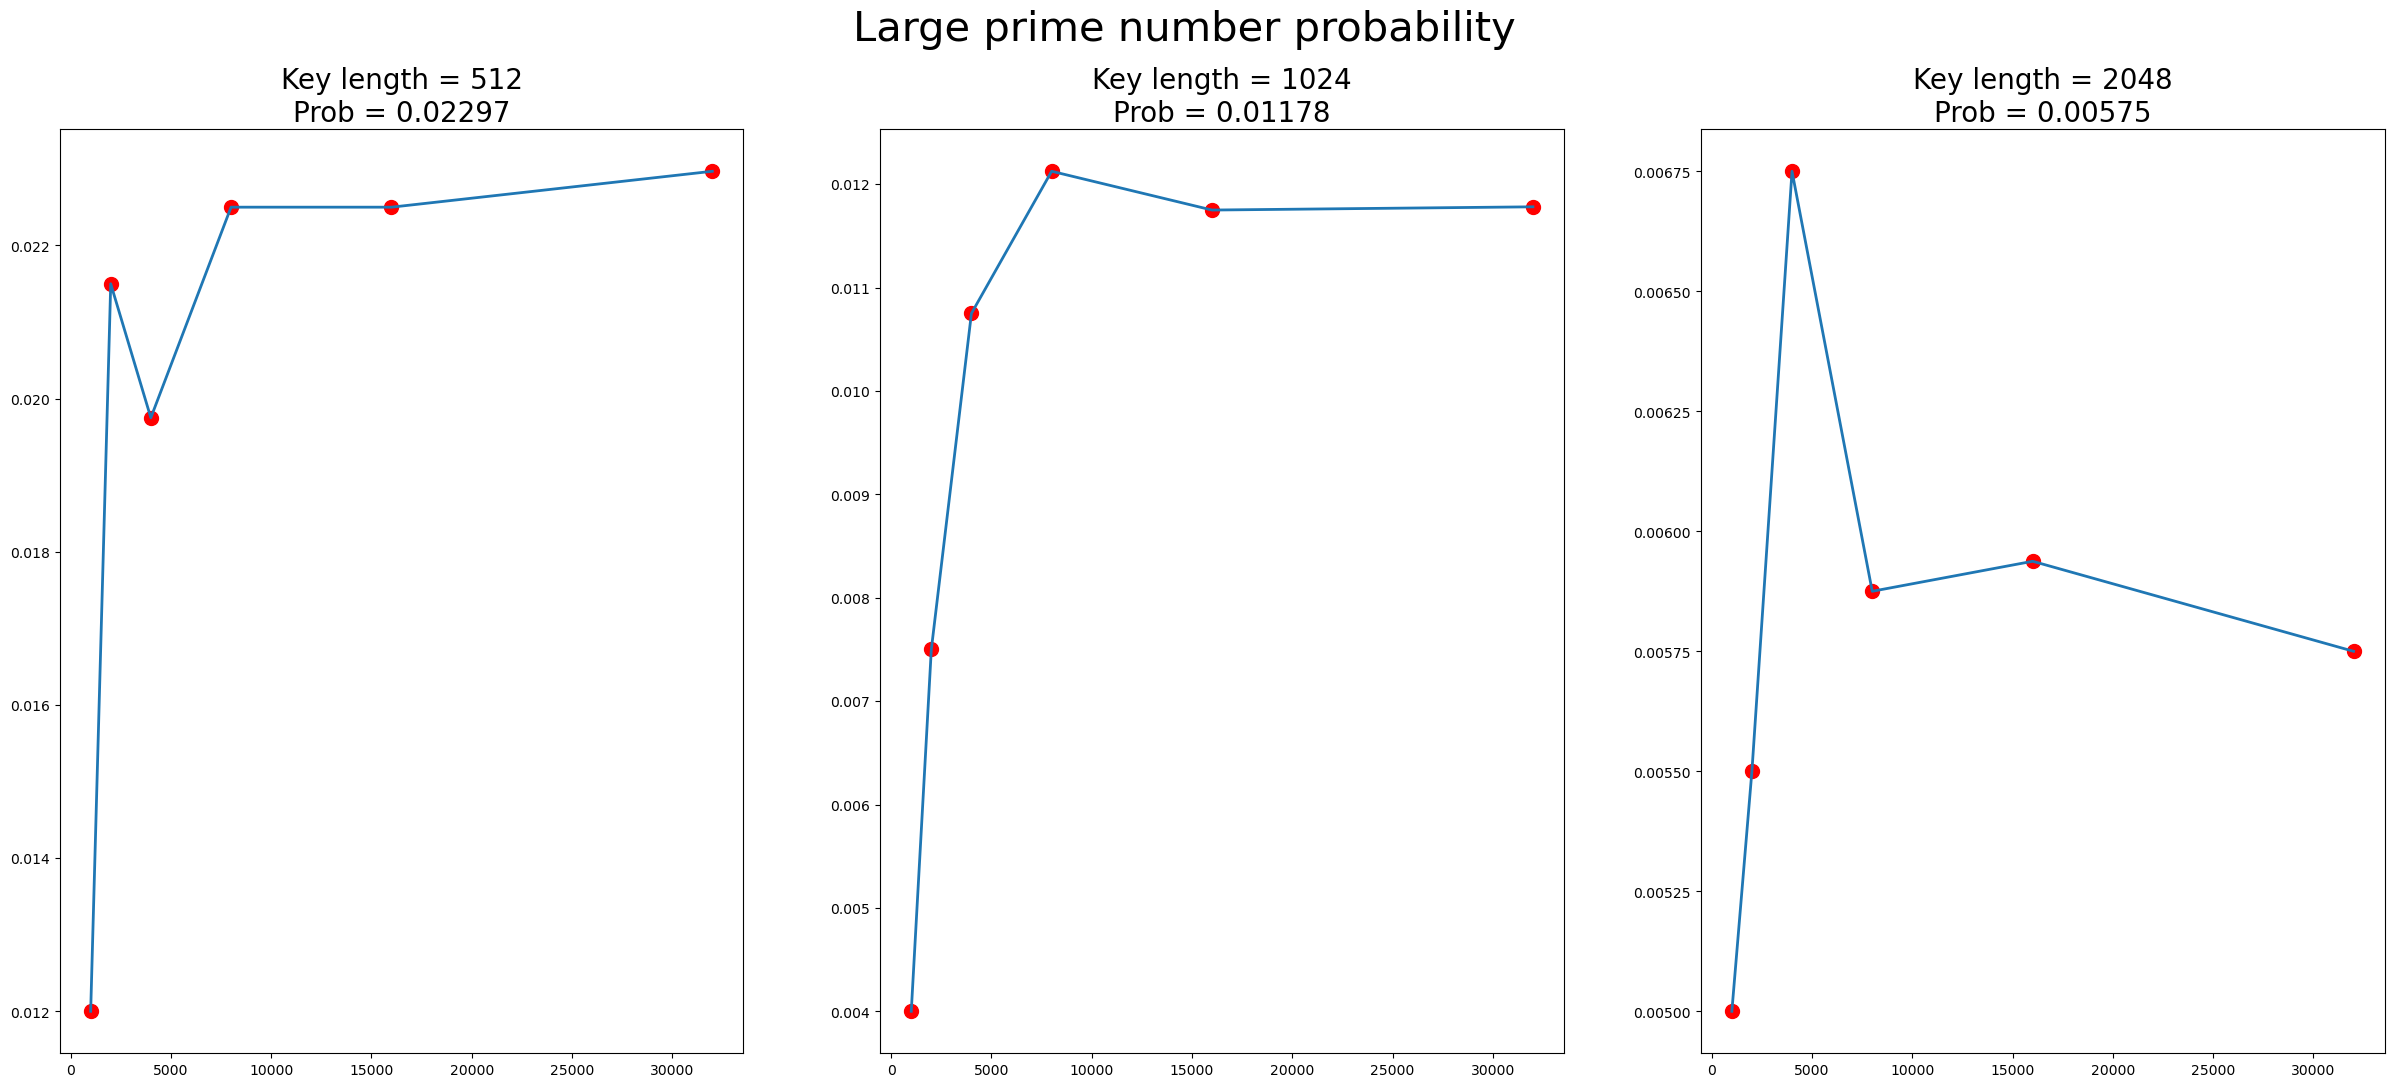

In [10]:
key_lengths = [512, 1024, 2048]
fig, axs = plt.subplots(1, 3, figsize=(30,12))
fig.suptitle('Large prime number probability', fontsize=30)
for idx, length in enumerate(key_lengths):
    est, prob = ProbabilityToBePrime(length, 0.1, 1000, 128000)
    axs[idx].plot(list(est.keys()), list(est.values()), linewidth=2)
    axs[idx].scatter(list(est.keys()), list(est.values()), color='r', s=100)
    axs[idx].set_title(f'Key length = {length}\nProb = {prob:.5f}', fontsize=20)


The generated plot confirm what was previously aniticipated: the larger are the generated random numbers, the lower is the probability to be prime

## Conclusions

This notebook focused on asymmetric ciphers, describing their general functioning and typical usage. In particular RSA was deeply discussed, showing all the preliminary procedure to generate the keys and the involved algorithms to make it more efficient. A possible implementation was then proposed and tested, both individually and coupled with AES to simulate a possibly real scenario where these ciphers can be used. In the end, exploting a Monte Carlo simulation, we estimated the probability for a large odd integer to be prime, that is a central aspect of RSA key generation process.

 ## References

[1] [Asymmetric Ciphers](https://en.wikipedia.org/wiki/Public-key_cryptography)

[2] [RSA](https://en.wikipedia.org/wiki/RSA_(cryptosystem))

[3] [Miller Rabin Primality Test](https://en.wikipedia.org/wiki/Miller%E2%80%93Rabin_primality_test)

[4] [Extended Euclidean Algorithm](https://en.wikipedia.org/wiki/Extended_Euclidean_algorithm)

[5] [Square and Multiply]()

[6] [AES]()

[7] [Monte Carlo Method]()